# Health effects of temperature change (is now indicator 1.2 in 2018 edition)

## Countries
1.1 (->1.2)

- Brazil

OLD:

- USA
- India
- France

## Output


Excel spreadsheet: Columns -> countries, Rows -> years

Generate plots anyways

Generate maps


In [3]:
%matplotlib inline

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [18]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.1 temperature change')

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'


COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'


### Load country data

In [13]:
# COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))

In [14]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

### Load the temperature anomaly data

In [15]:
# Load the anomaly raster
summer_anom = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'summer_temperature_anomaly.nc')

In [17]:
RESULTS_FOLDER / 'temperature_change.xlsx'

PosixPath('results/lancet2019/1.1 temperature/temperature_change.xlsx')

In [47]:
global_timeseries = pd.read_excel(RESULTS_FOLDER / 'temperature_change.xlsx', 
                                sheet_name='temperature_change').set_index('year')

In [48]:
global_timeseries.head()

Global mean change K  Exposure weighted change K
year                                                  
2000             -0.054708                    0.023712
2001              0.061469                    0.080554
2002              0.054207                    0.286307
2003              0.106125                    0.265867
2004              0.038934                   -0.041317

## Load the population data

In [24]:
population = xr.open_dataarray(POPULATION_FILE)

## Exposure weighted change by country

In [27]:
weighted_results = []
    
for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_population = (country_mask * population).sum(dim=['latitude', 'longitude'])
    country_exposures_ts = (summer_anom * population * country_mask / country_population).sum(dim=['latitude', 'longitude'])

    weighted_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

weighted_results = pd.concat(weighted_results, axis=1)

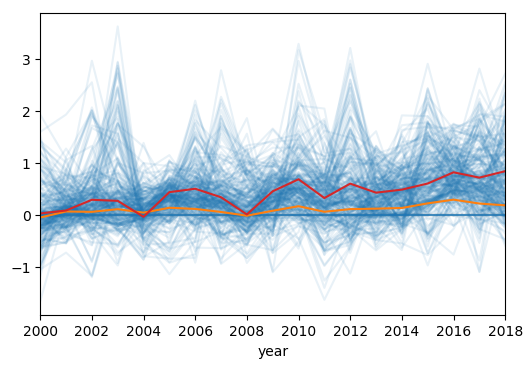

In [50]:
weighted_results.plot(style='C0', legend=False, alpha=0.1)
global_timeseries['Global mean change K'].plot(style='C1', legend=False)
global_timeseries['Exposure weighted change K'].plot(style='C3', legend=False)

In [67]:
# Append the results to the excel file as a new sheet
with pd.ExcelWriter(RESULTS_FOLDER / f'temperature_change.xlsx', mode='a') as writer:
    weighted_results.to_excel(writer, sheet_name='countries_exposure_weighted')

# Area wieghted plots by country

In [52]:
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat + pixel_size/2, center_lat - pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area = (np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
        area_list.append(area)
    return (pixel_size / 360.) * (area_list[0] - area_list[1])

In [54]:
pixel_areas = area_of_pixel(0.5, summer_anom.latitude)
globe_areas = xr.ones_like(summer_anom.sel(year=2000, drop=True)) * pixel_areas

In [63]:
mean_results = []
    
for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_area = (country_mask * globe_areas).sum(dim=['latitude', 'longitude'])
    country_mean_ts = (summer_anom * globe_areas * country_mask / country_area).sum(dim=['latitude', 'longitude'])

    mean_results.append(country_mean_ts.to_dataframe(row.ISOCODE))

mean_results = pd.concat(mean_results, axis=1)

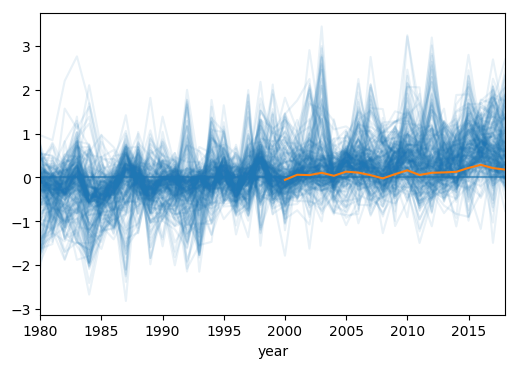

In [65]:
mean_results.plot(style='C0', legend=False, alpha=0.1)
global_timeseries['Global mean change K'].plot(style='C1', legend=False)
# global_timeseries['Exposure weighted change K'].plot(style='C3', legend=False)

### Plots

In [1]:
# SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL']

# for h in results:
    
#     country_name = COUNTRIES_NAMES[h]
    
#     f, ax = plt.subplots()
#     results[h].plot(color='C3', 
#                            linewidth=2,
#                            ax=ax,legend=False,
#                            label=f'{country_name}, exposure weighted')
#     summer_exposures_ts.plot(color='C0',
#                             alpha=0.6,
#                             label='Global, exposure weighted', 
#                             ax=ax)
#     summer_anom_ts.plot(color='C1',
#                               alpha=0.6,
#                               label='Global, area weighted',
#                               ax=ax)

#     ax.set_xlabel('Year')
#     ax.set_ylabel('''Mean change in summer temperature (˚C)''')
#     ax.set_title(f'{country_name}')
#     plt.legend()
#     plt.xticks(results.index[0::2])
    
#     f.savefig(ANOM_PLOTS / f'{h}_summer_temperature_change.png', 
#               dpi=300, bbox_inches='tight')
